In [2]:
import openeo
import xarray
import matplotlib.pyplot as plt

In [3]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [4]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [24]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2024-07-01", "2024-08-01"),  # Zamiast zakresu, podaj konkretny dzień
    spatial_extent={
        "west": 21.05,  # Zmodyfikowane współrzędne
        "south": 52.13,
        "east": 21.07,
        "north": 52.14,
        "crs": "EPSG:4326",
    },
    bands=["B08", "B11"],
    max_cloud_cover=20,
)

In [25]:
s2_cube.download("load-raw.nc")

In [21]:
# Wczytaj dane z pliku

ds = xarray.load_dataset("load-raw.nc")


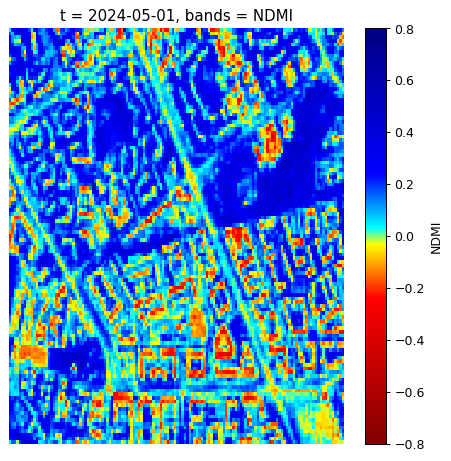

In [34]:

from matplotlib.colors import LinearSegmentedColormap


# Oblicz NDMI
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj DataSet na DataArray (bands, t, x, y)
data = ds[["NDMI"]].to_array(dim="bands")

# Definiujemy wartości NDMI i odpowiadające im kolory w formacie RGB
# Przeskalowujemy wartości na przedział [0, 1], który jest wymagany przez LinearSegmentedColormap
moisture_ramps = [
    (-0.8, '#800000'),  # ciemnoczerwony
    (-0.24, '#ff0000'),  # czerwony
    (-0.032, '#ffff00'),  # żółty
    (0.032, '#00ffff'),  # cyjan
    (0.24, '#0000ff'),  # niebieski
    (0.8, '#000080')    # ciemnoniebieski
]

# Tworzymy dostosowaną mapę kolorów
colors = [color for _, color in moisture_ramps]
positions = [(val + 0.8) / 1.6 for val, _ in moisture_ramps]  # Przeskalowujemy wartości NDMI na zakres [0, 1]

cmap = LinearSegmentedColormap.from_list("custom_moisture_cmap", list(zip(positions, colors)))

# Ustawienia wykresu
fig, ax = plt.subplots(figsize=(6, 6), dpi=90)

# Wyświetl pierwszy dzień (t=0) na wykresie z nową mapą kolorów
im = data[{"bands": 0, "t": 0}].plot.imshow(
    vmin=-0.8, vmax=0.8, cmap=cmap,  # Użycie dostosowanej mapy kolorów
    cbar_kwargs={"label": "NDMI"}
)

# Usunięcie osi i tytułów
ax.axis('off')

# Zapisz wynik jako obraz PNG bez dodatkowych elementów
plt.savefig("maps/ndmi_streets_clean.png", bbox_inches='tight', pad_inches=0)

# Wyświetlenie wyniku
plt.show()


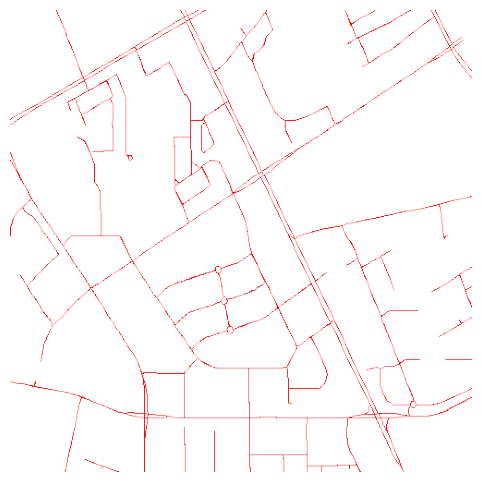

In [32]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Definicja miejsca: Ursynów, Warszawa, Polska
place_name = "Ursynow, Warsaw, Poland"

# Pobranie grafu ulicznego dla Ursynowa
G = ox.graph_from_place(place_name, network_type='drive')

# Pobranie krawędzi (ulic) z grafu
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Ustawienia obrazu
width, height = 500, 500  # Rozmiar obrazu
background_color = (255, 255, 255, 0)  # Przezroczyste tło
line_color = (255, 0, 0, 255)  # Czerwony kolor linii z pełną nieprzezroczystością

# Tworzenie nowego obrazu z przezroczystym tłem (RGBA)
image = Image.new("RGBA", (width, height), background_color)
draw = ImageDraw.Draw(image)

# Ustawienia granic geograficznych dla Ursynowa
lon_min, lon_max = 21.05, 21.07
lat_min, lat_max = 52.13, 52.14

# Funkcja do konwersji współrzędnych geograficznych na piksele
def geo_to_pixel(lon, lat, width, height, lon_min, lon_max, lat_min, lat_max):
    x = int((lon - lon_min) / (lon_max - lon_min) * width)
    y = height - int((lat - lat_min) / (lat_max - lat_min) * height)  # Inwersja osi y
    return x, y

# Rysowanie ulic na obrazie
for _, row in edges.iterrows():
    coords = row['geometry'].coords
    for i in range(len(coords) - 1):
        x1, y1 = geo_to_pixel(coords[i][0], coords[i][1], width, height, lon_min, lon_max, lat_min, lat_max)
        x2, y2 = geo_to_pixel(coords[i + 1][0], coords[i + 1][1], width, height, lon_min, lon_max, lat_min, lat_max)
        draw.line((x1, y1, x2, y2), fill=line_color, width=1)

# Zapisanie obrazu do pliku PNG z przezroczystym tłem
os.makedirs("maps", exist_ok=True)
image_path = "maps/kabaty_streets_pixelated_transparent.png"
image.save(image_path, "PNG")

# Wyświetlenie obrazu w Jupyter Notebook
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()
